## Simple Model

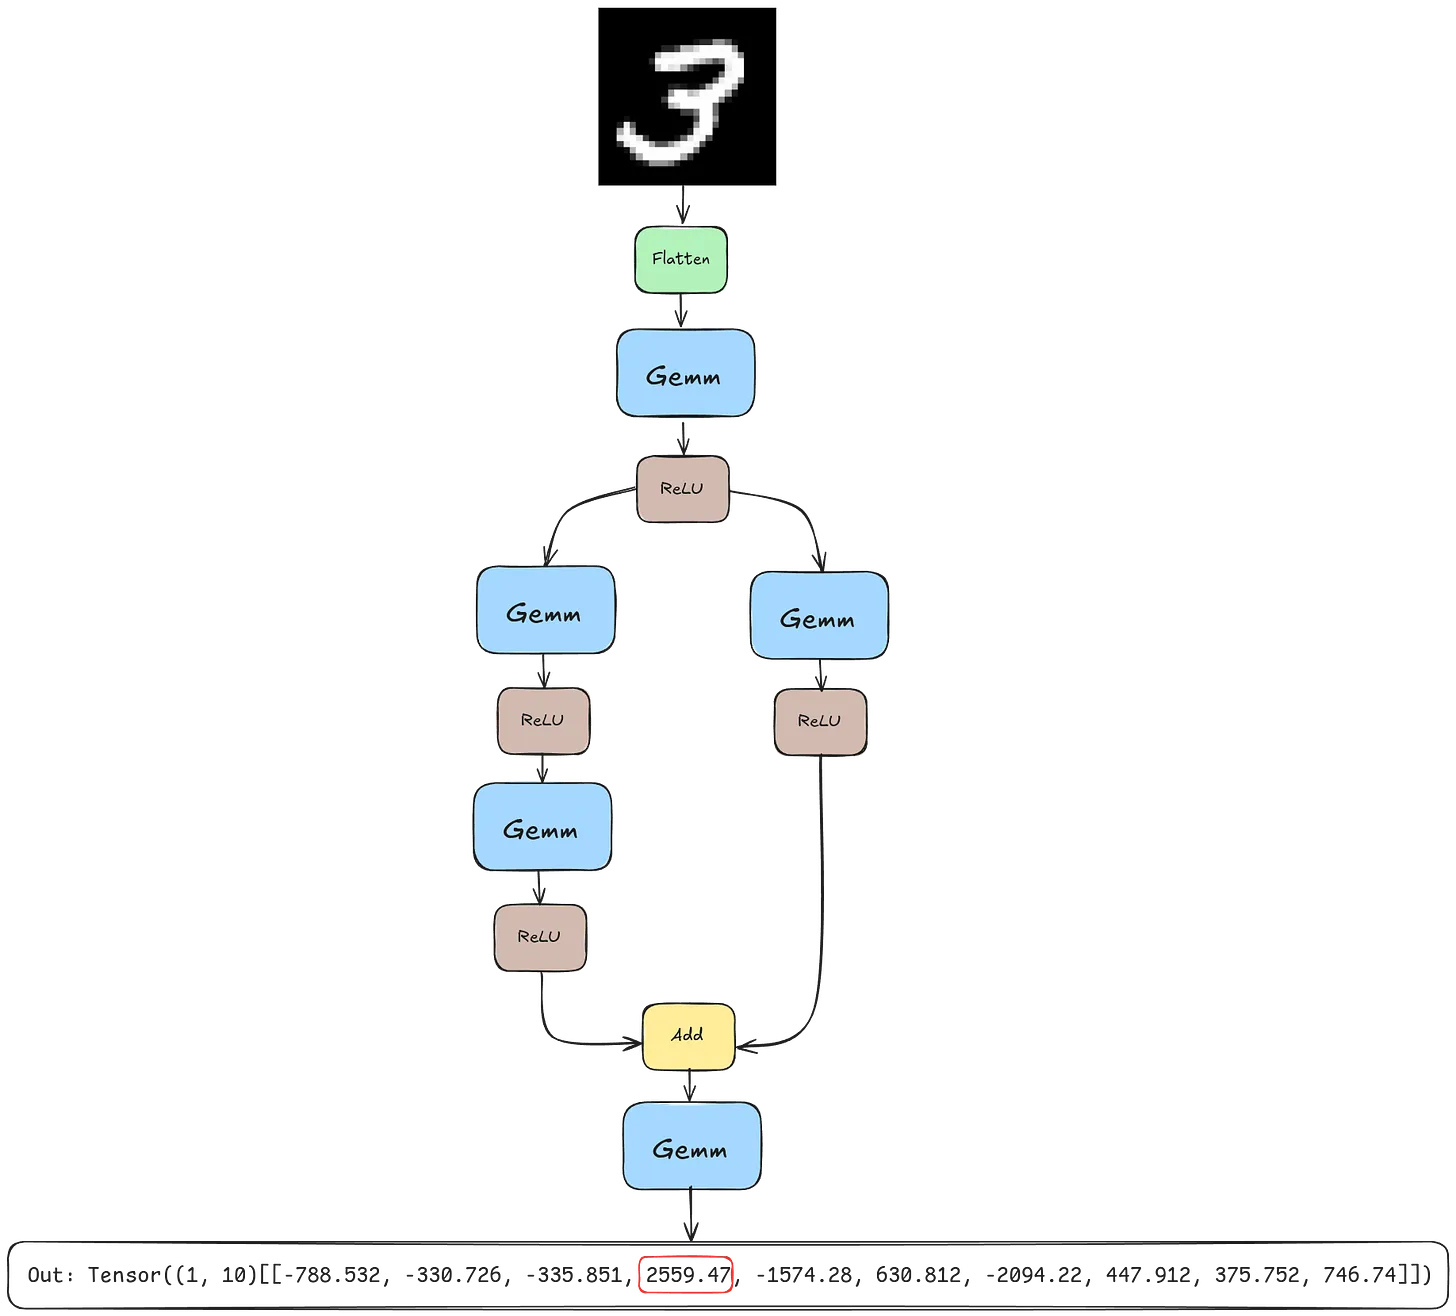

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 5)
        self.fc2_left2 = nn.Linear(5, 5)
        self.fc2_right = nn.Linear(5, 5)
        self.fc3 = nn.Linear(5, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        left = torch.relu(self.fc2_left2(x))
        right = torch.relu(self.fc2_right(x))
        x = torch.add(left, right)
        x = self.fc3(x)
        return x

## Dataloaders

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([transforms.ToTensor()])
train_loader = torch.utils.data.DataLoader(datasets.MNIST('./data', train=True, download=True, transform=transform),
                                        batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(datasets.MNIST('./data', train=False, transform=transform),
                                        batch_size=1000, shuffle=False)

## Training

In [20]:
model = Net().to(device)
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

Net(
  (fc1): Linear(in_features=784, out_features=5, bias=True)
  (fc2_left2): Linear(in_features=5, out_features=5, bias=True)
  (fc2_right): Linear(in_features=5, out_features=5, bias=True)
  (fc3): Linear(in_features=5, out_features=10, bias=True)
)


In [21]:
for epoch in range(10):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'Epoch {epoch+1} - Test loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')

Epoch 1 - Test loss: 0.0011, Accuracy: 65.23%
Epoch 2 - Test loss: 0.0007, Accuracy: 78.17%
Epoch 3 - Test loss: 0.0006, Accuracy: 80.45%
Epoch 4 - Test loss: 0.0006, Accuracy: 82.87%
Epoch 5 - Test loss: 0.0005, Accuracy: 82.82%
Epoch 6 - Test loss: 0.0005, Accuracy: 84.85%
Epoch 7 - Test loss: 0.0005, Accuracy: 85.69%
Epoch 8 - Test loss: 0.0005, Accuracy: 85.92%
Epoch 9 - Test loss: 0.0005, Accuracy: 86.28%
Epoch 10 - Test loss: 0.0005, Accuracy: 87.14%


## Export as ONNX

In [22]:
dummy_input = torch.randn(1, 1, 28, 28, device=device)
torch.onnx.export(model, dummy_input, "model.onnx")